In [15]:
# Imports:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import dxchange
import nibabel as nib
import tifffile
from skimage.filters import threshold_otsu
os.chdir('/dtu/3d-imaging-center/courses/02509/groups/members/s194333/HPC3D_project')

In [16]:
folder_path = '/dtu/3d-imaging-center/courses/02509/groups/group01/Lava_data/Island_ny/'
file_name = 'lavasten_Island_ny_LFOV-80kV-LE2-1.8s-21.8micro_recon.txm'
absolute_path = os.path.join(folder_path, file_name)
all_data = dxchange.reader.read_txm(absolute_path)

In [17]:
print(all_data[1].keys())
data = all_data[0]
pixel_size = all_data[1]['pixel_size']
print(pixel_size)
img_shape = data.shape
print(img_shape)
img_shape_array = np.array(img_shape)
total_size = img_shape_array * pixel_size
total_size__mm = total_size/1000
print(total_size__mm)
pixel_size_mm = pixel_size/1000
pixels_per_mm = 1/pixel_size_mm
print(pixels_per_mm)

dict_keys(['facility', 'image_width', 'image_height', 'data_type', 'number_of_images', 'pixel_size', 'reference_filename', 'reference_data_type', 'thetas', 'x_positions', 'y_positions', 'z_positions', 'x-shifts', 'y-shifts', 'reference'])
21.822635650634766
(1018, 1024, 1004)
[22.21544309 22.34637891 21.90992619]
45.823979101759534


779


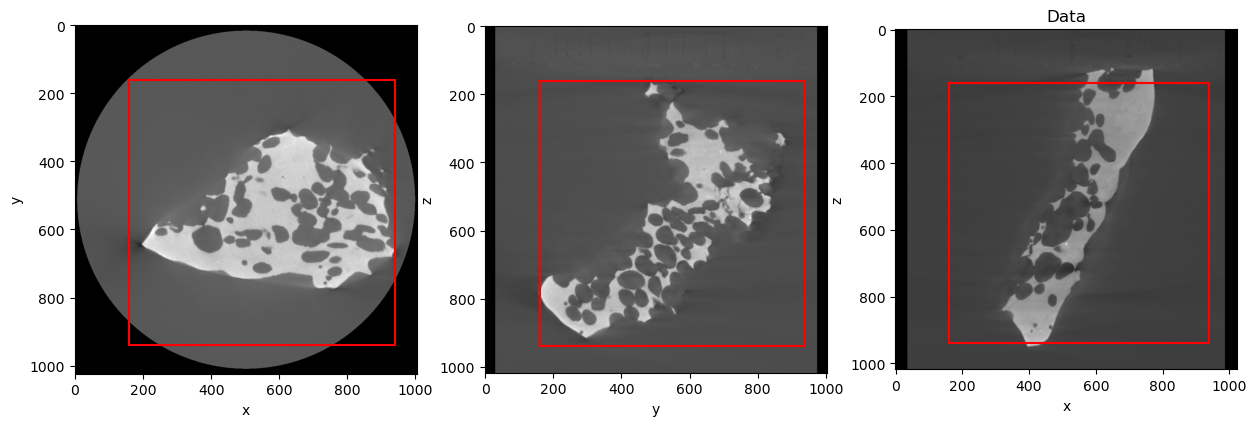

In [18]:
# crop 5mm times 5mm times 5mm
crop_size = int(17*pixels_per_mm)
print(crop_size)

# visualize the data
start_x = 160
end_x = start_x + crop_size
start_y = 160
end_y = start_y + crop_size
start_z = 160
end_z = start_z + crop_size
slice = 200# crop_size
slice_x = start_x + slice
slice_y = start_y + slice
slice_z = start_z + slice
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(data[slice_z, :, :], cmap='gray')
# visualize the crop box
ax[0].plot([start_x, end_x], [start_y, start_y], 'r')
ax[0].plot([start_x, end_x], [end_y, end_y], 'r')
ax[0].plot([start_x, start_x], [start_y, end_y], 'r')
ax[0].plot([end_x, end_x], [start_y, end_y], 'r')
# ad axes labels
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].imshow(data[:,slice_x, :], cmap='gray')
ax[1].plot([start_y, end_y], [start_z, start_z], 'r')
ax[1].plot([start_y, end_y], [end_z, end_z], 'r')
ax[1].plot([start_y, start_y], [start_z, end_z], 'r')
ax[1].plot([end_y, end_y], [start_z, end_z], 'r')
ax[1].set_xlabel('y')
ax[1].set_ylabel('z')
ax[2].imshow(data[:, :, slice_y], cmap='gray')
ax[2].plot([start_x, end_x], [start_z, start_z], 'r')
ax[2].plot([start_x, end_x], [end_z, end_z], 'r')
ax[2].plot([start_x, start_x], [start_z, end_z], 'r')
ax[2].plot([end_x, end_x], [start_z, end_z], 'r')
ax[2].set_xlabel('x')
ax[2].set_ylabel('z')
plt.title('Data')
plt.show()

In [19]:
data_crop = data[start_z:end_z, start_x:end_x, start_y:end_y]
global_threshold_otsu = threshold_otsu(data_crop)
print(global_threshold_otsu)

22479


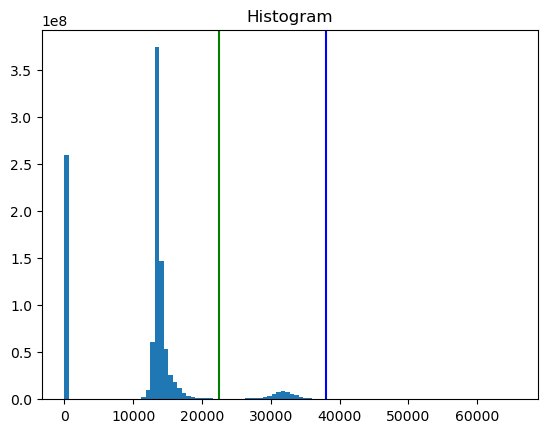

In [20]:
air_stone_threshold = global_threshold_otsu
stone_krystal_threshold = 38000
# make histogram
plt.hist(data.flatten(), bins=100)
plt.axvline(air_stone_threshold, color='g')
plt.axvline(stone_krystal_threshold, color='b')
plt.title('Histogram')
plt.show()


In [21]:
data_air = data < air_stone_threshold
data_stone = (data > air_stone_threshold) & (data < stone_krystal_threshold)
data_krystal = data > stone_krystal_threshold

segmented_data = np.zeros(data.shape)
segmented_data[data_air] = 0
segmented_data[data_stone] = 1
segmented_data[data_krystal] = 2


In [22]:
# do some closing
from skimage.morphology import closing, isotropic_closing, disk, ball, cube
footprint = cube(51)
bin_data = data > global_threshold_otsu
bin_data = bin_data.astype(np.uint8)
closed_data = closing(bin_data, footprint)

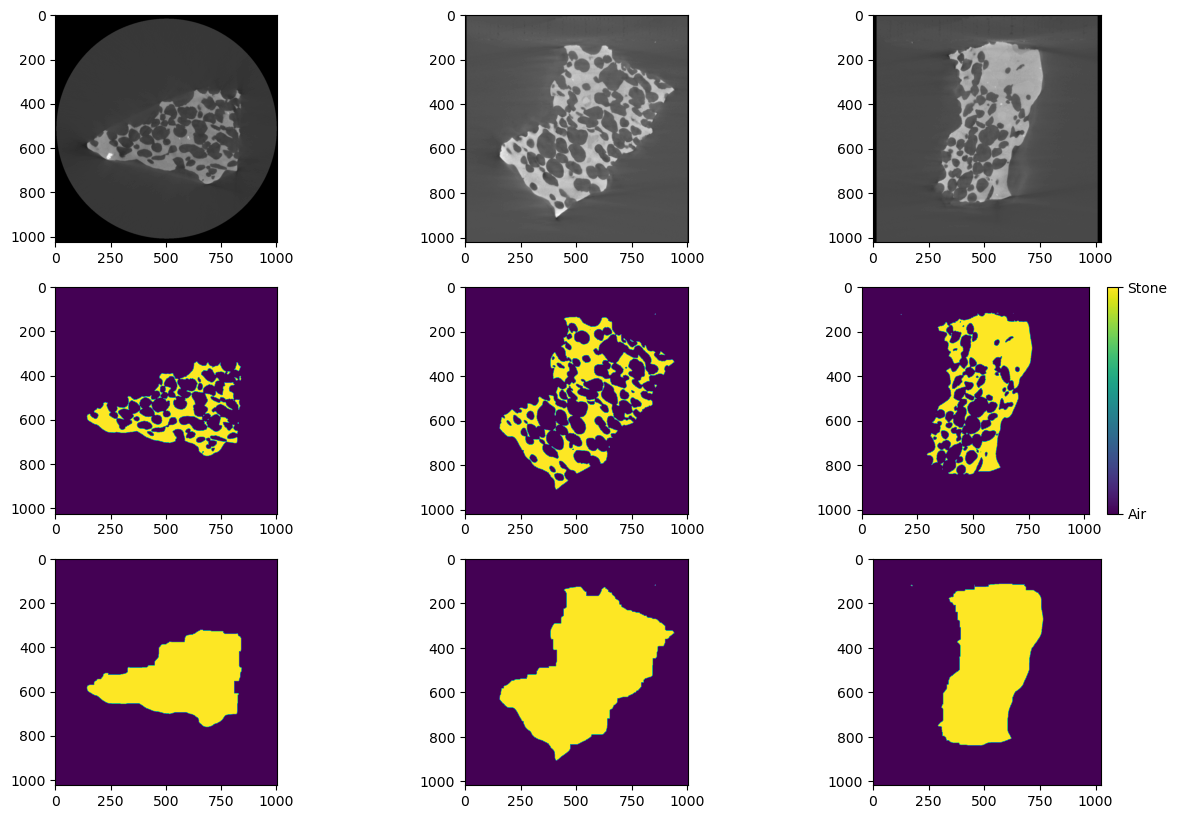

In [23]:
# visualize the segmented data
slice = 500
fig, ax = plt.subplots(3, 3, figsize=(15, 10))
ax[0,0].imshow(data[slice, :, :], cmap='gray')
ax[0,1].imshow(data[:,slice, :], cmap='gray')
ax[0,2].imshow(data[:, :, slice], cmap='gray')
ax[1,0].imshow(bin_data[slice, :, :])
ax[1,1].imshow(bin_data[:,slice, :])
ax[1,2].imshow(bin_data[:, :, slice])
ax[2,0].imshow(closed_data[slice, :, :])
ax[2,1].imshow(closed_data[:,slice, :])
ax[2,2].imshow(closed_data[:, :, slice])
# color bar
cbar = plt.colorbar(ax[1,2].imshow(bin_data[:, :, slice]))
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Air', 'Stone'])

plt.show()

In [24]:
# save croped data
folder_path = 'results'
file_name = 'data.tiff'
absolute_path = os.path.join(folder_path, file_name)
dxchange.write_tiff(data, absolute_path, dtype='uint16', overwrite=True)


# save the bin data
file_name = 'bin_data.tiff'
absolute_path = os.path.join(folder_path, file_name)
dxchange.write_tiff(bin_data, absolute_path, dtype='uint8', overwrite=True)

# save the segmented data
file_name = 'closed_data.tiff'
absolute_path = os.path.join(folder_path, file_name)
dxchange.write_tiff(closed_data, absolute_path, dtype='uint8', overwrite=True)
